In [23]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

import scipy.stats as stats
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

import datetime as dt
from datetime import timezone, timedelta

In [24]:
timezone_offset = -5.0  # Eastern Standard Time (UTC−08:00)
tzinfo = timezone(timedelta(hours=timezone_offset))
current_dateTime = datetime.now(tzinfo)

In [25]:
begin_date = '2024-08-12T00:00:00.000-05:00'
#end_date = '2024-08-14T11:00:00.000-05:00'
end_date = current_dateTime.strftime('%Y-%m-%dT%H:%M:%S.%f%z')


In [26]:
print(end_date)

2024-10-31T14:28:07.919636-0500


In [27]:
print(current_dateTime.strftime('%Y-%m-%dT%H:%M:%S.%f%z'))

2024-10-31T14:28:07.919636-0500


In [28]:
#print(end_date)

In [29]:
#Read in raw stream gage data
gage = pd.read_csv('https://nwis.waterservices.usgs.gov/nwis/iv/?sites=08393610&parameterCd=00065&startDT='+begin_date+'&endDT='+end_date+'&siteStatus=all&format=rdb', sep='\t', skiprows=26)
gage = gage.iloc[1: , :]

In [30]:
gage

,agency_cd,site_no,datetime,tz_cd,101398_00065,101398_00065_cd
1,USGS,08393610,2024-08-11 23:00,MDT,5.98,P
2,USGS,08393610,2024-08-11 23:15,MDT,5.98,P
3,USGS,08393610,2024-08-11 23:30,MDT,5.99,P
4,USGS,08393610,2024-08-11 23:45,MDT,5.99,P
5,USGS,08393610,2024-08-12 00:00,MDT,5.99,P
...,...,...,...,...,...,...
7731,USGS,08393610,2024-10-31 11:30,MDT,7.78,P
7732,USGS,08393610,2024-10-31 11:45,MDT,7.78,P
7733,USGS,08393610,2024-10-31 12:00,MDT,7.78,P
7734,USGS,08393610,2024-10-31 12:15,MDT,7.77,P


In [31]:
gage['101398_00065'] = gage['101398_00065'].astype(float)
gage = gage[['datetime','101398_00065']]
gage = gage.set_index('datetime')
gage['item_id'] = 'gage'
gage  = gage.rename(columns={"101398_00065": "series"})
gage.head()

,series,item_id
datetime,,
2024-08-11 23:00,5.98,gage
2024-08-11 23:15,5.98,gage
2024-08-11 23:30,5.99,gage
2024-08-11 23:45,5.99,gage
2024-08-12 00:00,5.99,gage


In [32]:
#Read in raw flow data
flow = pd.read_csv('https://waterservices.usgs.gov/nwis/iv/?sites=08393610&parameterCd=00060&startDT='+begin_date+'&endDT='+end_date+'&siteStatus=all&format=rdb', sep='\t', skiprows=26)
flow = flow.iloc[1: , :]

In [33]:
flow

,agency_cd,site_no,datetime,tz_cd,101399_00060,101399_00060_cd
1,USGS,08393610,2024-08-11 23:00,MDT,1.87,P
2,USGS,08393610,2024-08-11 23:15,MDT,1.87,P
3,USGS,08393610,2024-08-11 23:30,MDT,1.95,P
4,USGS,08393610,2024-08-11 23:45,MDT,1.95,P
5,USGS,08393610,2024-08-12 00:00,MDT,1.95,P
...,...,...,...,...,...,...
7731,USGS,08393610,2024-10-31 11:30,MDT,66.4,P
7732,USGS,08393610,2024-10-31 11:45,MDT,66.4,P
7733,USGS,08393610,2024-10-31 12:00,MDT,66.4,P
7734,USGS,08393610,2024-10-31 12:15,MDT,65.8,P


In [34]:
flow['101399_00060'] = flow['101399_00060'].astype(float)
flow = flow[['datetime','101399_00060']]# Merge datasets together on datetime index and check if everything is good
flow = flow.set_index('datetime')
flow['item_id'] = 'flow'

            
#df=pd.merge(gage, flow, how='inner', left_index=True, right_index=True)
#df.head()
flow  = flow.rename(columns={"101399_00060": "series"})

flow.head()

,series,item_id
datetime,,
2024-08-11 23:00,1.87,flow
2024-08-11 23:15,1.87,flow
2024-08-11 23:30,1.95,flow
2024-08-11 23:45,1.95,flow
2024-08-12 00:00,1.95,flow


In [35]:
merge = pd.concat([gage, flow])

In [36]:
merge

,series,item_id
datetime,,
2024-08-11 23:00,5.98,gage
2024-08-11 23:15,5.98,gage
2024-08-11 23:30,5.99,gage
2024-08-11 23:45,5.99,gage
2024-08-12 00:00,5.99,gage
...,...,...
2024-10-31 11:30,66.40,flow
2024-10-31 11:45,66.40,flow
2024-10-31 12:00,66.40,flow


In [37]:
merge.reset_index(inplace=True)

#merge

In [38]:
test_data = TimeSeriesDataFrame.from_data_frame(merge, id_column="item_id", timestamp_column='datetime') #, timestamp_column=merge.index
test_data = test_data.convert_frequency(freq='h', agg_numeric="max")
test_data.head()

series
item_id timestamp                  
gage    2024-08-11 23:00:00    5.99
        2024-08-12 00:00:00    5.99
        2024-08-12 01:00:00    5.99
        2024-08-12 02:00:00    5.99
        2024-08-12 03:00:00    5.99

In [39]:
prediction_length = 6

In [40]:
predictor = TimeSeriesPredictor.load("rio_hondo_gage_autogluon_"+str(prediction_length), require_version_match=False)

This means that the predictor was fit in a version `<=0.7.0`.

############################## WARNING ##############################
	Predictor Version: Unknown (Likely <=0.7.0)
	Current Version:   1.0.0
############################## WARNING ##############################



In [41]:
predictions = predictor.predict(test_data)

data with frequency 'h' has been resampled to frequency 'H'.
/Users/tott/opt/anaconda3/envs/py310/lib/python3.10/site-packages/autogluon/timeseries/dataset/ts_dataframe.py:942: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)


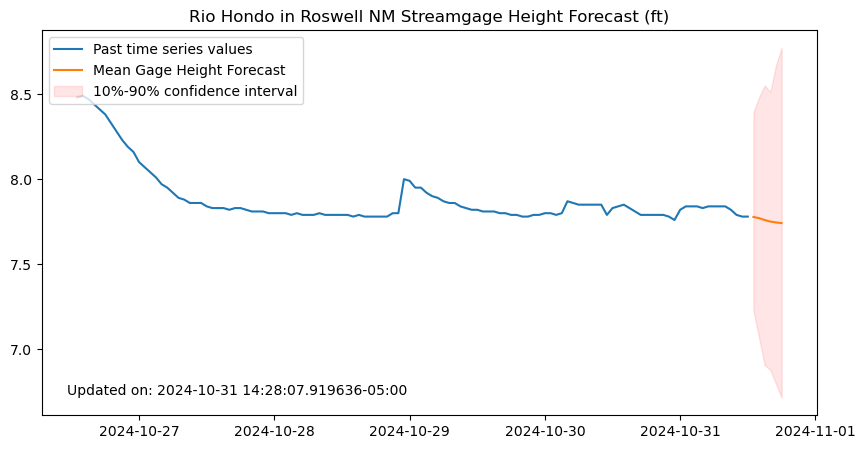

In [42]:
item_id = 'gage'

plt.figure(figsize=(10, 5))
plt.title('Rio Hondo in Roswell NM Streamgage Height Forecast (ft)')


y_past = test_data.loc[item_id]
y_pred = predictions.loc[item_id]

plt.plot(y_past[-120:], label="Past time series values")
plt.plot(y_pred["mean"], label="Mean Gage Height Forecast")
#plt.plot(y_test, label="Future time series values")

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
#plt.figtext(0.5, 0.01, "Note: Route 23 Typically Closes At Gage Height Of 18 feet", ha="center", fontsize=12, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
plt.figtext(0.15, 0.15, 'Updated on: '+str(current_dateTime), ha='left', fontsize=10)
plt.legend(loc = 'upper left');
plt.savefig('static/'+item_id+'-rio-hondo-forecast.png')

In [43]:
y_pred[['mean', '0.1', '0.9']]

,mean,0.1,0.9
timestamp,,,
2024-10-31 13:00:00,7.777832,7.226507,8.392832
2024-10-31 14:00:00,7.770887,7.068052,8.480956
2024-10-31 15:00:00,7.759917,6.906790,8.549764
2024-10-31 16:00:00,7.750631,6.879950,8.511478
2024-10-31 17:00:00,7.745814,6.797303,8.668979
2024-10-31 18:00:00,7.741833,6.715910,8.771450


In [44]:
print(current_dateTime)

2024-10-31 14:28:07.919636-05:00
